In [1]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [2]:
SEDM_ML_sample = Table.read("/home/xhall/Documents/NewZTF/ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [3]:
snidoutput = np.load("/home/xhall/Documents/NewZTF/SNIDoutput.npy",allow_pickle=True)

In [7]:
final_rcf_table_all = Table.from_pandas(pd.read_hdf("/home/xhall/Documents/NewZTF/final_rcf_table.h5"))

In [10]:
indicies = []
counter = 0
for i in final_rcf_table_all:
    if("Ia" in i["sn_type"]):
        indicies.append(counter)
    counter+=1

In [13]:
final_rcf_table = final_rcf_table_all[indicies]

In [14]:
ZTable_best_only = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    row.append(float(j[1][0]["z"]))
    row.append(float(j[1][0]["zerr"]))
    ZTable_best_only.add_row(row)
ZTable_best_only_JoinedResults = astropy.table.join(astropy.table.join(ZTable_best_only, SEDM_ML_sample),final_rcf_table)

In [15]:
print(len(ZTable_best_only))
print(len(SEDM_ML_sample))

8374
8959


In [16]:
regr_best_only_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_best_only_JoinedResults_good = ZTable_best_only_JoinedResults[np.where(ZTable_best_only_JoinedResults["z_host"] > -.1)[0]]
regr_best_only_JoinedResults_good.fit(ZTable_best_only_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_best_only_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [17]:
ranges_best_good = np.linspace(0, .2, 100)
ypredict_best_only_good = regr_best_only_JoinedResults_good.predict(ranges_best_good.reshape(-1, 1))

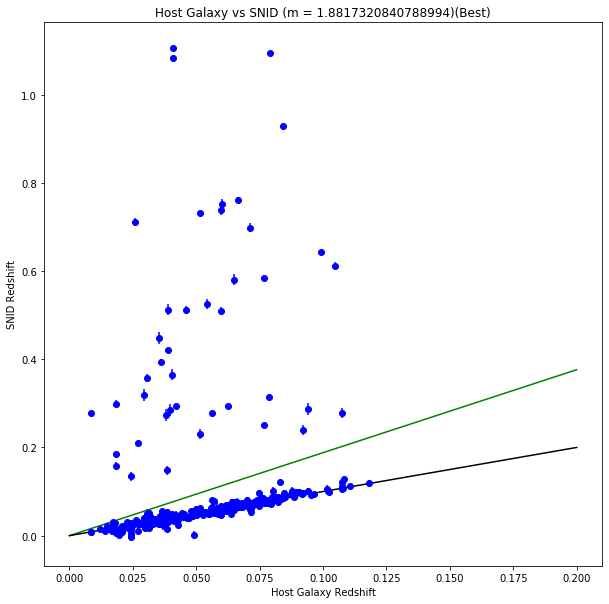

In [18]:
fig = plt.figure(figsize = (10,10))
#plt.xlim(0,.2)
#plt.ylim(0,.2)
plt.errorbar(ZTable_best_only_JoinedResults_good["z_host"], ZTable_best_only_JoinedResults_good["z_snid"], ZTable_best_only_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_only_JoinedResults_good.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_best_good, ypredict_best_only_good, color = "green")
plt.plot(ranges_best_good, ranges_best_good, color = "black")

In [52]:
print(stats.median_absolute_deviation(ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"])/ZTable_best_only_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]))
print(np.std((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_host"]))
print(np.std(((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_best_only_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.006852577200000001
0.13201878035687076
1.5230015226860267
0.16424917351724544
3.8979883924342205
41.14740325048804
533 547


In [74]:
print(np.sum(np.abs((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"])/ZTable_best_only_JoinedResults_good["z_host"]) > .5),len(ZTable_best_only_JoinedResults_good))

58 343


In [21]:
ZTable_best = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        row.append(float(good[0]["z"]))
        row.append(float(good[0]["zerr"]))
        ZTable_best.add_row(row)
ZTable_best_JoinedResults = astropy.table.join(astropy.table.join(ZTable_best, SEDM_ML_sample),final_rcf_table)

In [22]:
print(len(ZTable_best))
print(len(SEDM_ML_sample))

6368
8959


In [23]:
regr_best_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_best_JoinedResults_good = ZTable_best_JoinedResults[np.where(ZTable_best_JoinedResults["z_host"] > -.1)[0]]
regr_best_JoinedResults_good.fit(ZTable_best_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_best_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [24]:
ranges_best_good = np.linspace(0, .2, 100)
ypredict_best_good = regr_best_JoinedResults_good.predict(ranges_best_good.reshape(-1, 1))

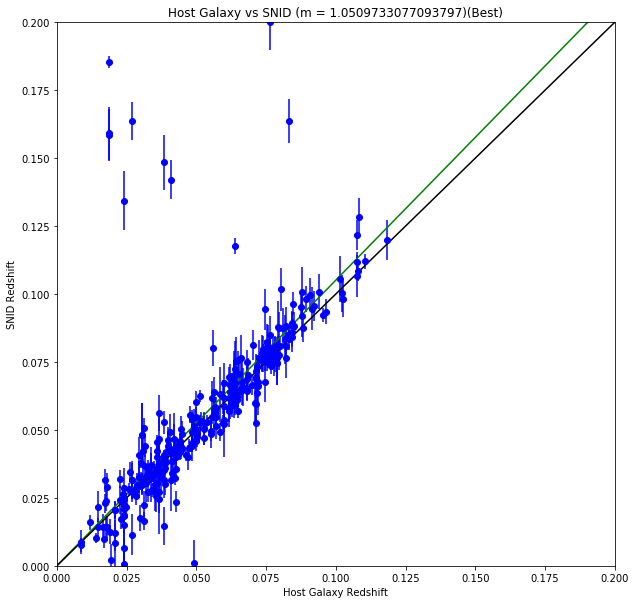

In [25]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_best_JoinedResults_good["z_host"], ZTable_best_JoinedResults_good["z_snid"], ZTable_best_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_JoinedResults_good.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_best_good, ypredict_best_good, color = "green")
plt.plot(ranges_best_good, ranges_best_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Best)')

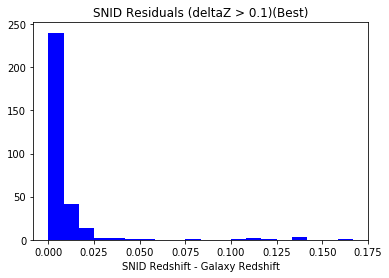

In [26]:
plt.hist(np.abs(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Best)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Best)')

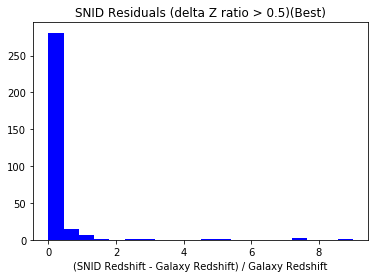

In [27]:
plt.hist(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Best)")

In [75]:
print(np.sum(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]) > .5),len(ZTable_best_JoinedResults_good))

27 310


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Best)')

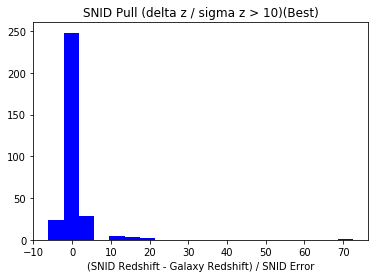

In [29]:
plt.hist(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Best)")

In [53]:
print(stats.median_absolute_deviation(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(np.std((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_host"]))
print(np.std(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_best_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.00561905399999999
0.11229447751444446
1.3287361249999992
0.022853374144179005
0.9412829540755357
4.975973956015222
518 547


In [31]:
ZTable_average = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        if(np.sum(good[0:15]["zerr"] == 0) == 0):
            row.append(float(sum(good[0:15]["z"] * (1/(good[0:15]["zerr"] ** 2)))/sum(1/(good[0:15]["zerr"] ** 2))))
            row.append(float(1 / (np.sqrt(np.sum(1 / good[0:15]["zerr"] ** 2)))))
            ZTable_average.add_row(row)
ZTable_average_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average, SEDM_ML_sample),final_rcf_table)

In [32]:
print(len(ZTable_average))
print(len(SEDM_ML_sample))

6328
8959


In [33]:
regr_average_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_JoinedResults_good = ZTable_average_JoinedResults[np.where(ZTable_average_JoinedResults["z_host"] > -.1)[0]]
regr_average_JoinedResults_good.fit(ZTable_average_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [34]:
ranges_average_good = np.linspace(0, .2, 100)
ypredict_average_good = regr_average_JoinedResults_good.predict(ranges_average_good.reshape(-1, 1))

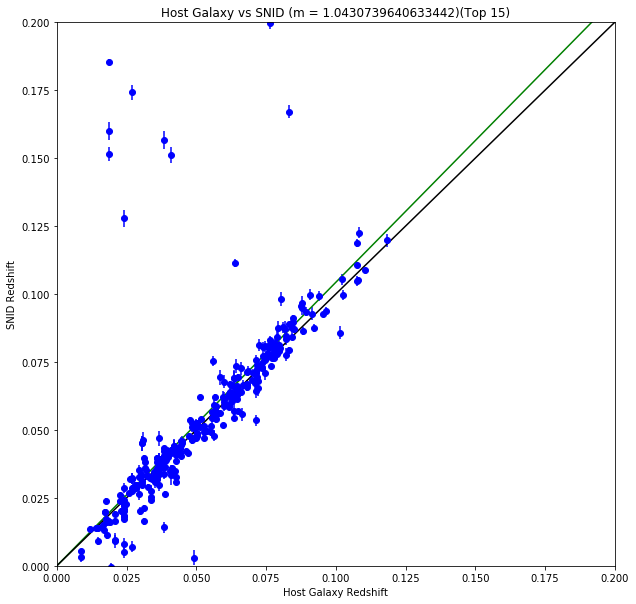

In [35]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_JoinedResults_good["z_host"], ZTable_average_JoinedResults_good["z_snid"], ZTable_average_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_JoinedResults_good.coef_[0][0]) + ")(Top 15)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_good, ypredict_average_good, color = "green")
plt.plot(ranges_average_good, ranges_average_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15)')

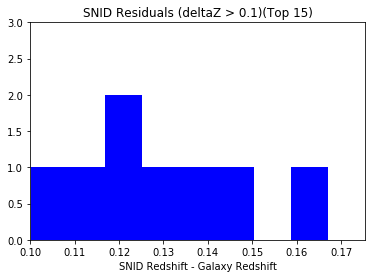

In [36]:
plt.hist(np.abs(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,3)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15)')

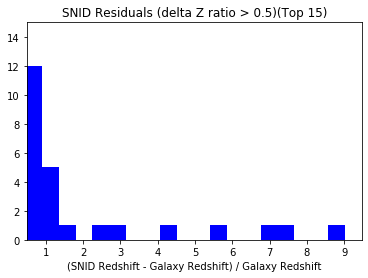

In [37]:
plt.hist(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,15)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15)")

In [76]:
print(np.sum(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]) > .5),len(ZTable_average_JoinedResults_good))

22 308


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

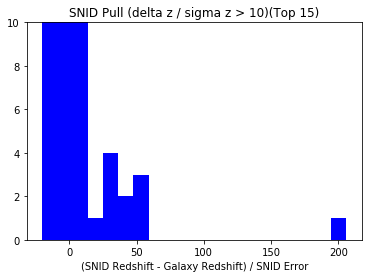

In [39]:
plt.hist(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [54]:
print(stats.median_absolute_deviation(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.004335278932209429
0.08611571673470489
3.249901621752811
0.022775259508397774
0.9342426363189954
14.395919440451669
518 547


In [41]:
ZTable_average_same = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        if(len(correct) != 0):
            if(np.sum(correct[0:15]["zerr"] == 0) == 0):
                row.append(float(sum(correct[0:15]["z"] * (1/(correct[0:15]["zerr"] ** 2)))/sum(1/(correct[0:15]["zerr"] ** 2))))
                row.append(float(1 / (np.sqrt(np.sum(1 / correct[0:15]["zerr"] ** 2)))))
                ZTable_average_same.add_row(row)
ZTable_average_same_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same, SEDM_ML_sample),final_rcf_table)

In [42]:
print(len(ZTable_average_same))
print(len(SEDM_ML_sample))

6240
8959


In [43]:
regr_average_same_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_JoinedResults_good = ZTable_average_same_JoinedResults[np.where(ZTable_average_same_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_JoinedResults.fit(ZTable_average_same_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [44]:
ranges_average_same_good = np.linspace(0, .2, 100)
ypredict_average_same_good = regr_average_same_JoinedResults.predict(ranges_average_same_good.reshape(-1, 1))

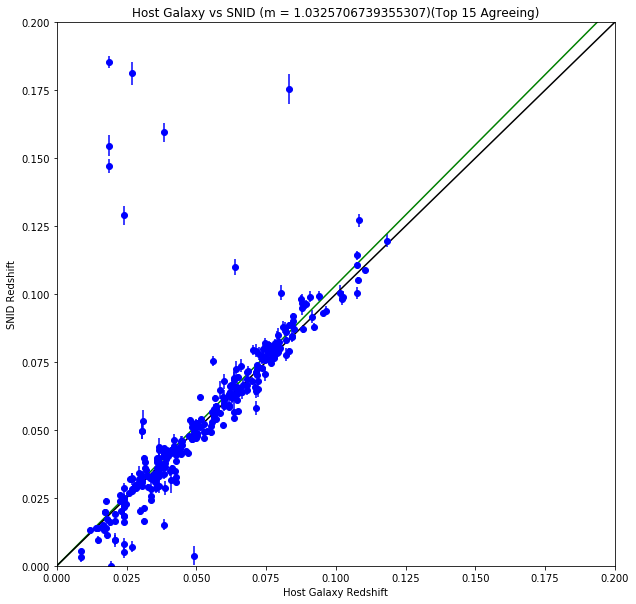

In [45]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_JoinedResults_good["z_host"], ZTable_average_same_JoinedResults_good["z_snid"], ZTable_average_same_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_JoinedResults.coef_[0][0]) + ")(Top 15 Agreeing)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good, ypredict_average_same_good, color = "green")
plt.plot(ranges_average_same_good, ranges_average_same_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)')

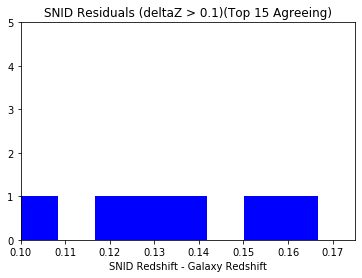

In [46]:
plt.hist(np.abs(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,5)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)')

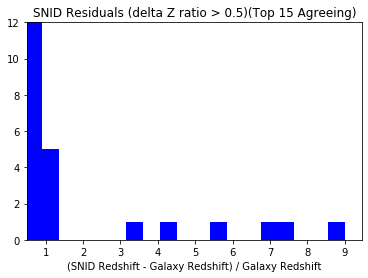

In [47]:
plt.hist(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,12)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)")

In [77]:
print(np.sum(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_JoinedResults_good))

22 306


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

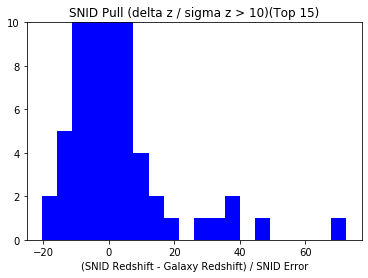

In [49]:
plt.hist(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [55]:
print(stats.median_absolute_deviation(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.004184351565770314
0.0831179954046809
3.033553673628757
0.02101046218011751
0.9145892854929765
7.633016053307613
518 547


In [57]:
unique_counter = 0
ZTable_average_same_unique = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        unique = np.unique(correct["sn"])
        if(len(unique) >= 7):
            indicies = []
            for i in unique[0:15]:
                indicies.append(np.where(correct["sn"] == i)[0][0])
            if(len(correct) != 0):
                if(np.sum(correct[indicies]["zerr"] == 0) == 0):
                    row.append(float(sum(correct[indicies]["z"] * (1/(correct[indicies]["zerr"] ** 2)))/sum(1/(correct[indicies]["zerr"] ** 2))))
                    row.append(float(1 / (np.sqrt(np.sum(1 / correct[indicies]["zerr"] ** 2)))))
                    ZTable_average_same_unique.add_row(row)
ZTable_average_same_unique_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same_unique, SEDM_ML_sample),final_rcf_table)

In [58]:
print(len(ZTable_average_same_unique))
print(len(SEDM_ML_sample))

5452
8959


In [59]:
regr_average_same_unique = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_unique_JoinedResults_good = ZTable_average_same_unique_JoinedResults[np.where(ZTable_average_same_unique_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_unique.fit(ZTable_average_same_unique_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_unique_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [60]:
ranges_average_same_unique_good = np.linspace(0, .2, 100)
ypredict_average_same_unique_good = regr_average_same_unique.predict(ranges_average_same_unique_good.reshape(-1, 1))

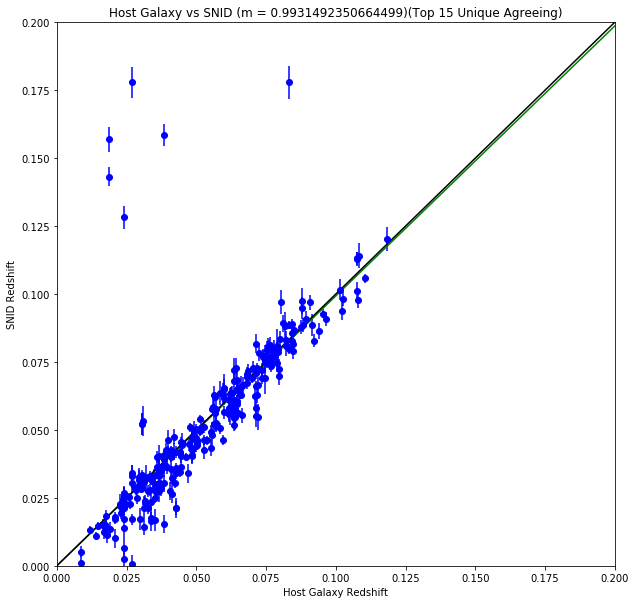

In [61]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_unique_JoinedResults_good["z_host"], ZTable_average_same_unique_JoinedResults_good["z_snid"], ZTable_average_same_unique_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_unique.coef_[0][0]) + ")(Top 15 Unique Agreeing)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_unique_good, ypredict_average_same_unique_good, color = "green")
plt.plot(ranges_average_same_unique_good, ranges_average_same_unique_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Unique Agreeing)')

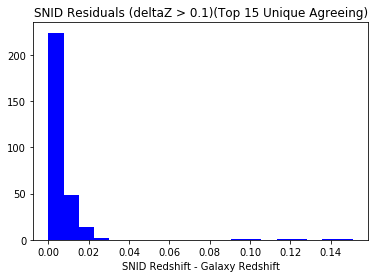

In [62]:
plt.hist(np.abs(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Unique Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Unique Agreeing Agreeing)')

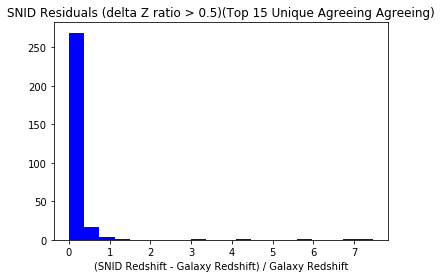

In [63]:
plt.hist(np.abs((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"])/ZTable_average_same_unique_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Unique Agreeing Agreeing)")

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top Unique Agreeing 15)')

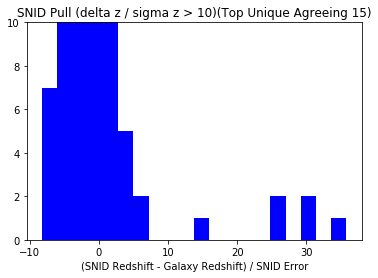

In [64]:
plt.hist(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top Unique Agreeing 15)")

In [65]:
print(stats.median_absolute_deviation(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_unique_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.005542882024125071
0.10613471708305021
2.0821203597065416
0.0189732321924283
0.7676801591360236
4.648922917138319
511 547


In [66]:
print(np.sum(np.abs((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"])/ZTable_average_same_unique_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_unique_best_JoinedResults_good))

20

In [67]:
unique_counter = 0
ZTable_average_same_unique_best = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        unique = np.unique(correct["sn"])
        if(len(unique) >= 7):
            indicies = []
            for i in unique[0:15]:
                indicies.append(np.where(correct["sn"] == i)[0][0])
            if(len(correct) != 0):
                if(np.sum(correct[indicies]["zerr"] == 0) == 0):
                    row.append(float(good[0]["z"]))
                    row.append(float(good[0]["zerr"]))
                    ZTable_average_same_unique_best.add_row(row)
ZTable_average_same_unique_best_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same_unique_best, SEDM_ML_sample),final_rcf_table)

In [68]:
regr_average_same_unique_best = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_unique_best_JoinedResults_good = ZTable_average_same_unique_best_JoinedResults[np.where(ZTable_average_same_unique_best_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_unique_best.fit(ZTable_average_same_unique_best_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_unique_best_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [69]:
ranges_average_same_unique_good = np.linspace(0, .2, 100)
ypredict_average_same_unique_best_good = regr_average_same_unique_best.predict(ranges_average_same_unique_good.reshape(-1, 1))

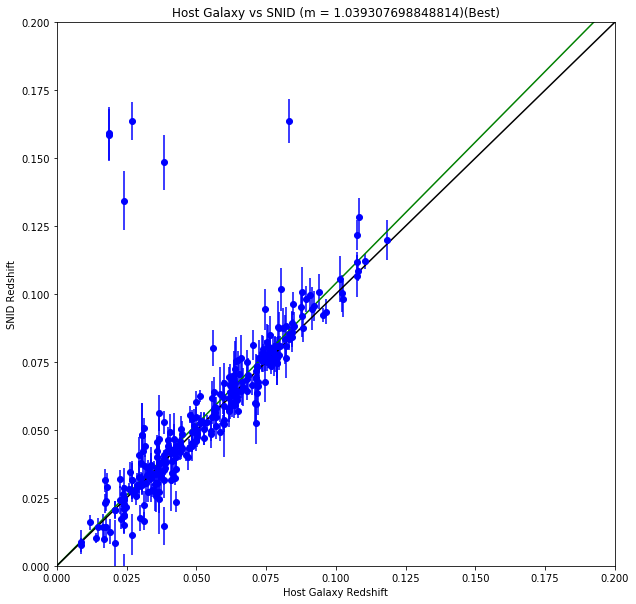

In [70]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_unique_best_JoinedResults_good["z_host"], ZTable_average_same_unique_best_JoinedResults_good["z_snid"], ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_unique_best.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_unique_good, ypredict_average_same_unique_best_good, color = "green")
plt.plot(ranges_average_same_unique_good, ranges_average_same_unique_good, color = "black")

In [73]:
print(np.sum(np.abs((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"])/ZTable_average_same_unique_best_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_unique_best_JoinedResults_good))

16 294


In [72]:
print(stats.median_absolute_deviation(ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_unique_best_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.005304001500000023
0.10608971517242885
1.1825322457279068
0.01840965321500263
0.7767899084205176
2.398774633106872
511 547
